# Exploratory Data Analysis

In [10]:
#import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime, date, timedelta
from pandas import DataFrame
import requests
import json
import random

In [2]:
#Download data set for explore a case count
url = "https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv"
data = pd.read_csv(url,
				 encoding= 'utf8', 
				 usecols=['Bundesland', 'AnzahlFall', 'Meldedatum'],
				 parse_dates=['Meldedatum'])

bundesland_cases = data.groupby(['Bundesland', 'Meldedatum'], as_index = False)['AnzahlFall'].sum()
bundesland_cases = bundesland_cases.set_index("Meldedatum").sort_index()
print(bundesland_cases)    

                     Bundesland  AnzahlFall
Meldedatum                                 
2020-01-02  Nordrhein-Westfalen           1
2020-01-12  Nordrhein-Westfalen           1
2020-01-14  Nordrhein-Westfalen           1
2020-01-18          Brandenburg           1
2020-01-28               Bayern           2
...                         ...         ...
2020-12-17   Schleswig-Holstein         469
2020-12-17               Hessen        1029
2020-12-17               Bremen         146
2020-12-17               Bayern        3804
2020-12-17            Thüringen        1078

[4542 rows x 2 columns]


                Bundesland  AnzahlFall
0        Baden-Württemberg      202050
1                   Bayern      277953
2                   Berlin       83669
3              Brandenburg       30092
4                   Bremen       12231
5                  Hamburg       31038
6                   Hessen      115453
7   Mecklenburg-Vorpommern        9227
8            Niedersachsen       91145
9      Nordrhein-Westfalen      339124
10         Rheinland-Pfalz       60752
11                Saarland       17109
12                 Sachsen       98829
13          Sachsen-Anhalt       20854
14      Schleswig-Holstein       19791
15               Thüringen       30274


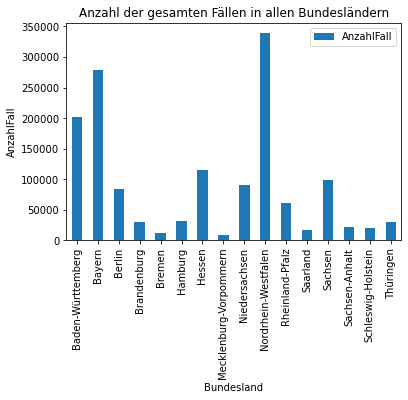

In [3]:
# accumulate cases per Bundesland

bundesland_cases_sum = data.groupby(['Bundesland'], as_index = False)['AnzahlFall'].sum()
print(bundesland_cases_sum)
bundesland_cases_sum.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

Folgende Schritte werden analysiert:
- Wir haben festgestellt, dass die meisten Cases in folgenden Bundesländer vorkommen:
  Baden-Württemberg, Bayern, Berlin, Hessen, Neidersachsen, NRW, Rheinland-Pfalz und Sachsen. Diese würden wir   ein bisschen genauer anschauen, um festzustellen, welche Maßnahmen dort eingeführt waren
- Und umgekehrt wollen wir die Bunderländer betrachten, die nicht so viele Anzahl der Fällen enthalten, welche Maßnahmen sind dort eingeführt
- Vergleichen die beiden Ergebnisse -> Abhängigkeiten herausfinden?



                Bundesland  AnzahlFall
4                   Bremen     12231.0
7   Mecklenburg-Vorpommern      9227.0
11                Saarland     17109.0
13          Sachsen-Anhalt     20854.0
14      Schleswig-Holstein     19791.0


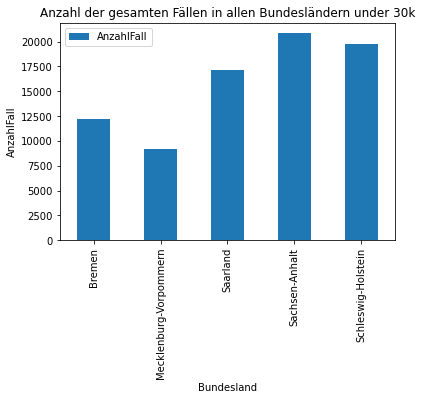

In [4]:
# making filter series for under 30k cases
filter = bundesland_cases_sum["AnzahlFall"]<30000
  
# filtering data on basis of both filters 
bundesland_cases_sum_under_30k = bundesland_cases_sum.where(filter).dropna()

print(bundesland_cases_sum_under_30k)
bundesland_cases_sum_under_30k.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern under 30k')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

In [5]:
#download data for restriction measures
country="Germany"
url="https://raw.githubusercontent.com/saudiwin/corona_tscs/master/data/CoronaNet/data_country/coronanet_release/coronanet_release_{0}.csv".format(country)
restriction_data=pd.read_csv(url, encoding='iso-8859-1')

In [7]:
#print(restriction_data)

restriction_data['target_province'] = restriction_data['target_province'].str.replace(';','')
restriction_data['target_province'] = restriction_data['target_province'].str.replace(r'^-$','Countrywide')
restriction_data[(restriction_data.target_province.isin(['-', np.nan]))] = restriction_data[(restriction_data.target_province.isin(['-', np.nan]))].assign(target_province = 'Countrywide')
           

filter=restriction_data["target_province"].str.contains('Berlin')
restriction_data_for_berlin = restriction_data.where(filter)#.dropna()

print(restriction_data_for_berlin)


      Unnamed: 0 record_id  policy_id entry_type correct_type update_type  \
0            NaN       NaN        NaN        NaN          NaN         NaN   
1            NaN       NaN        NaN        NaN          NaN         NaN   
2            NaN       NaN        NaN        NaN          NaN         NaN   
3            NaN       NaN        NaN        NaN          NaN         NaN   
4            NaN       NaN        NaN        NaN          NaN         NaN   
...          ...       ...        ...        ...          ...         ...   
2456         NaN       NaN        NaN        NaN          NaN         NaN   
2457         NaN       NaN        NaN        NaN          NaN         NaN   
2458         NaN       NaN        NaN        NaN          NaN         NaN   
2459         NaN       NaN        NaN        NaN          NaN         NaN   
2460         NaN       NaN        NaN        NaN          NaN         NaN   

     update_level description date_announced date_start  ... travel_mechani